**TODO**:
* calibration : find the threshold value to select the right channel (meld 2 channels) -> see "calib_find_channel_selection_threshold" notebook
* rotation before Tino's geometry transformation ?
* optimize parameters for noise injection

In [1]:
#%matplotlib notebook
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 10)

import numpy as np
#np.set_printoptions(threshold=np.nan)
from matplotlib import pyplot as plt
from matplotlib import cm

import ctapipe
from ctapipe.io.hessio import hessio_event_source
import pyhessio

import sys
sys.path.append("../")

import datapipe
import datapipe.denoising.wavelets_mrfilter as mrfilter

sys.path.append("../utils")
import common_functions as common

from datapipe.io import images
from datapipe.io import geometry_converter

SST-1M = "DigiCam" (tel 410 to 567 in prod3b (Grid production) - **South site (Paranal)**), 1 channel

C.f. https://www.cta-observatory.org/project/technology/sst/

In [2]:
#%run ~/git/pub/jdhp-sap/snippets/ctapipe/list_telescopes_geometry.py /Users/jdecock/data/grid_prod3b_south/simtel/gamma/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz

In [3]:
#ctapipe.version.get_version()
print(ctapipe.__version__)
print(pyhessio.__version__)

import ctapipe.image.geometry_converter as geomconv
from ctapipe.instrument import CameraGeometry

0.5.1
2.0.1


In [4]:
# calibrator
from ctapipe.calib import CameraCalibrator

calib = CameraCalibrator(None, None)

In [5]:
from datapipe.denoising.inverse_transform_sampling import EmpiricalDistribution
import datapipe.denoising.cdf

In [6]:
tel_id = 410
simtel_file = "/Users/jdecock/data/grid_prod3b_south/simtel/gamma/gamma_20deg_0deg_run100___cta-prod3_desert-2150m-Paranal-merged.simtel.gz"
source = hessio_event_source(simtel_file, allowed_tels=[tel_id])

In [7]:
for ev in source:
    calib.calibrate(ev)  # calibrate the event
    break

In [8]:
# CHECK THE IMAGE GEOMETRY ################################

x, y = ev.inst.pixel_pos[tel_id]
foclen = ev.inst.optical_foclen[tel_id]
geom = ctapipe.instrument.camera.CameraGeometry.guess(x, y, foclen)

if (geom.pix_type != "hexagonal") or (geom.cam_id not in ("DigiCam",)):
    raise ValueError("Telescope {}: error (the input image is not a valide DigiCam telescope image): {} ({})".format(tel_id, geom.cam_id, geom.pix_type))

In [9]:
#print(ev)

In [10]:
# GET IMAGES ##############################################

channel = 0

pe = ev.mc.tel[tel_id].photo_electron_image
pedestal = ev.mc.tel[tel_id].pedestal[channel]
gain = ev.mc.tel[tel_id].dc_to_pe[channel]
uncalibrated_image = ev.r0.tel[tel_id].adc_sums[channel]

calibrated_image = ev.dl1.tel[tel_id].image[channel]

pixel_pos = ev.inst.pixel_pos[tel_id]

event_id = ev.dl0.event_id

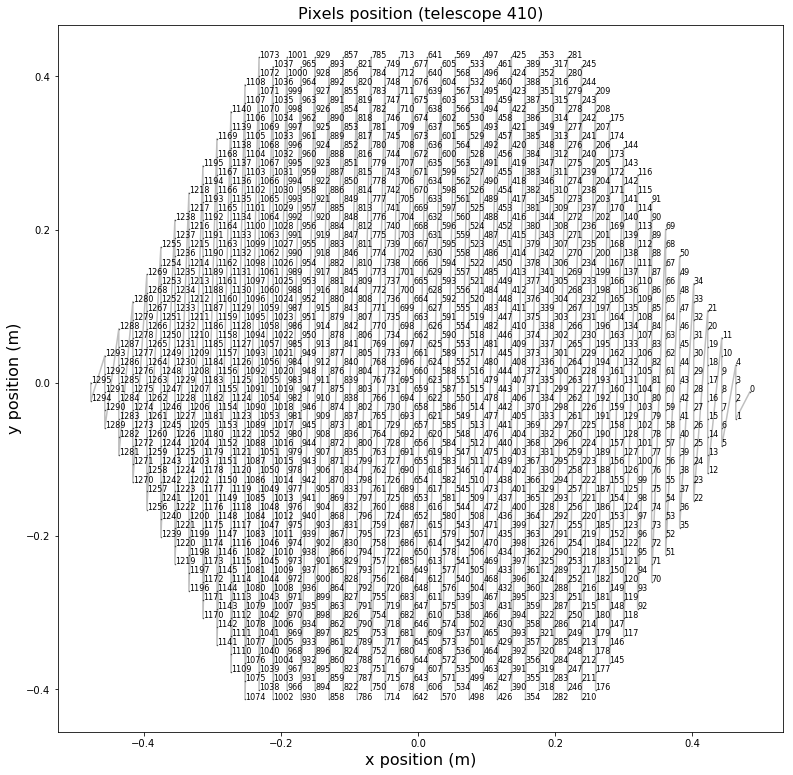

In [11]:
# %load ~/git/pub/jdhp-sap/snippets/ctapipe/plot_pixels_index.py
#!/usr/bin/env python3

"""
Display the pixel layout of the givent telescope as defined in a given simtel file.
"""

(pos_x_list, pos_y_list) = pixel_pos
pos_x_list = [float(pos.value) for pos in pos_x_list]
pos_y_list = [float(pos.value) for pos in pos_y_list]

assert len(pos_x_list) == len(pos_y_list)

# PLOT ####################################################################

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(13, 13))

# Scatter method ##################

ax.scatter(pos_x_list,    # x
           pos_y_list,    # y
           s=0.2,         # radius
           c="black",     # color
           alpha=0.75)

ax.plot(pos_x_list,    # x
        pos_y_list,    # y
        "k-",
        alpha=0.25)

for pixel_index in range(len(pos_x_list)):
    ax.text(pos_x_list[pixel_index], pos_y_list[pixel_index], str(pixel_index), fontsize=8)

ax.set_title("Pixels position (telescope {})".format(tel_id), fontsize=16)

ax.set_xlabel("x position (m)", fontsize=16)
ax.set_ylabel("y position (m)", fontsize=16)

#ax.set_xlim(-0.17, 0.17)
#ax.set_ylim(-0.17, 0.17)

plt.show()

### Plot image with ctapipe

In [12]:
image = calibrated_image   # pe, uncalibrated_image, calibrated_image

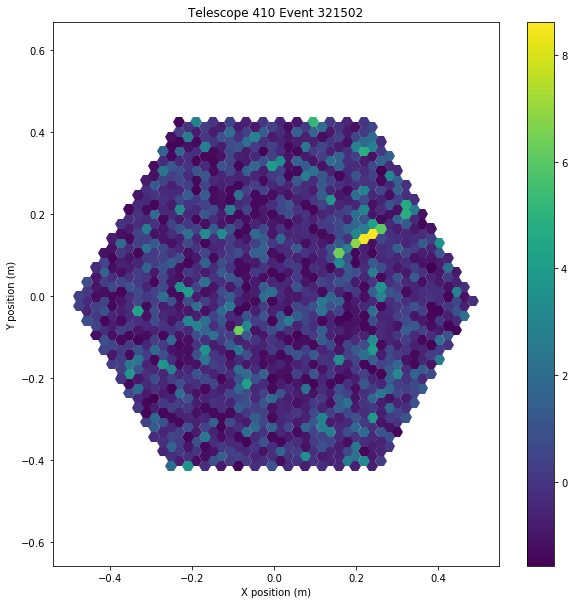

In [13]:
#%load ../../snippets/ctapipe/plot_events_image.py

import ctapipe
import ctapipe.visualization
from ctapipe.io.hessio import hessio_event_source

from matplotlib import pyplot as plt

x, y = ev.inst.pixel_pos[tel_id]
foclen = ev.inst.optical_foclen[tel_id]
geom = ctapipe.instrument.CameraGeometry.guess(x, y, foclen)

disp = ctapipe.visualization.CameraDisplay(geom,
                                           image=image,   # pe, adc_sum
                                           title='CT%d' % tel_id)
disp.enable_pixel_picker()
disp.add_colorbar()

disp.axes.set_title('Telescope {:03d} Event {}'.format(tel_id, event_id))

## 1D to 2D

In [14]:
cam_id = "DigiCam"
rot = 0

geom = CameraGeometry.from_name(cam_id)

if geom.pix_type=='rectangular':
    print("Error: skip non-hexagonal cameras, since they don't need conversion")

(1296,)
(48, 48)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


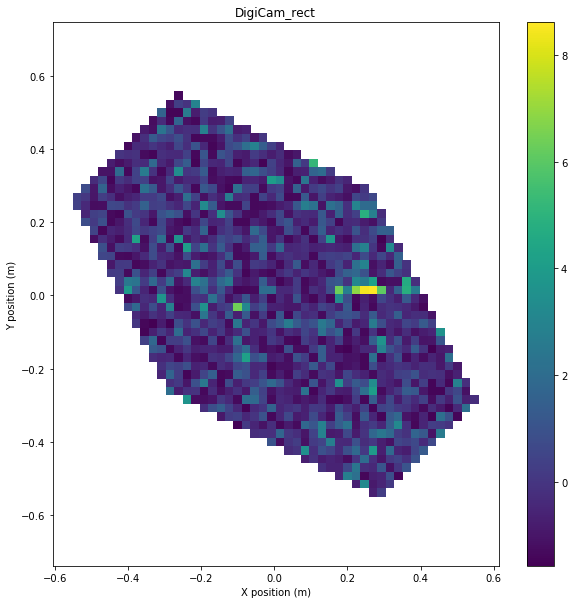

In [15]:
print(image.shape)
    
geom2d, image2d = geomconv.convert_geometry_1d_to_2d(geom,
                                                     image,
                                                     geom.cam_id + str(rot),
                                                     add_rot=0)

print(image2d.shape)
print(image2d)

disp = ctapipe.visualization.CameraDisplay(geom2d, image=image2d)
disp.enable_pixel_picker()
disp.add_colorbar()

#plt.scatter(geom2d.pix_x.min(), geom2d.pix_y.min(), c="red")
#plt.scatter(geom2d.pix_x.max(), geom2d.pix_y.max(), c="red")

(48, 48)
(48, 48)
(48, 48)
x_min: -0.5392192486559998 m
x_max: 0.5470843486812997 m
y_min: -0.5391149874226993 m
y_max: 0.5469774748095588 m


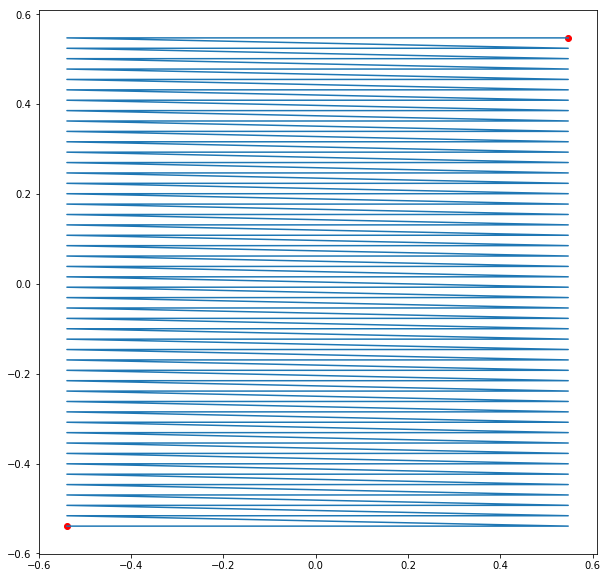

In [16]:
print(image2d.shape)

print(geom2d.pix_x.shape)
print(geom2d.pix_y.shape)

print("x_min:", geom2d.pix_x.min())
print("x_max:", geom2d.pix_x.max())
print("y_min:", geom2d.pix_y.min())
print("y_max:", geom2d.pix_y.max())

plt.plot(geom2d.pix_x.ravel(), geom2d.pix_y.ravel())

plt.scatter(geom2d.pix_x.min(), geom2d.pix_y.min(), c="red")
plt.scatter(geom2d.pix_x.max(), geom2d.pix_y.max(), c="red")

### Get and print the pixel mask of the new geometry

(48, 48)
[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


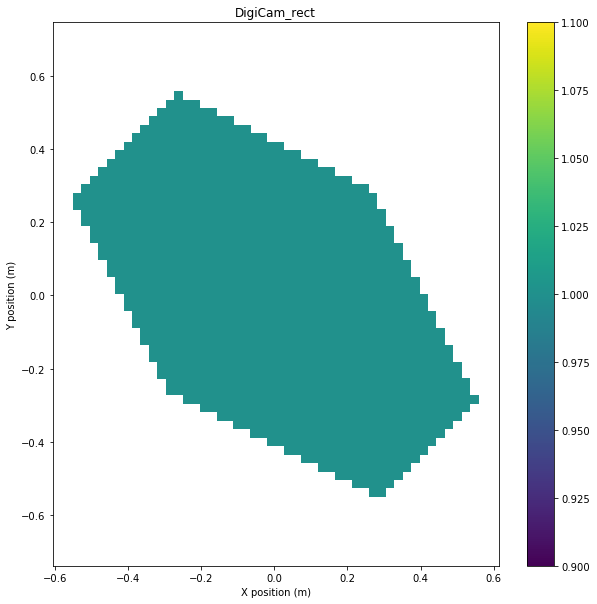

In [17]:
print(geom2d.mask.shape)
print(geom2d.mask)

disp = ctapipe.visualization.CameraDisplay(geom2d, image=geom2d.mask)
disp.enable_pixel_picker()
disp.add_colorbar()

### Put NaN in blank areas (instead 0)

This step is optional, the aim is to be closer to what is actually done in `datapipe`.

In [18]:
image2d[np.logical_not(geom2d.mask)] = np.nan

print(image2d)

[[ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 ..., 
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]
 [ nan  nan  nan ...,  nan  nan  nan]]


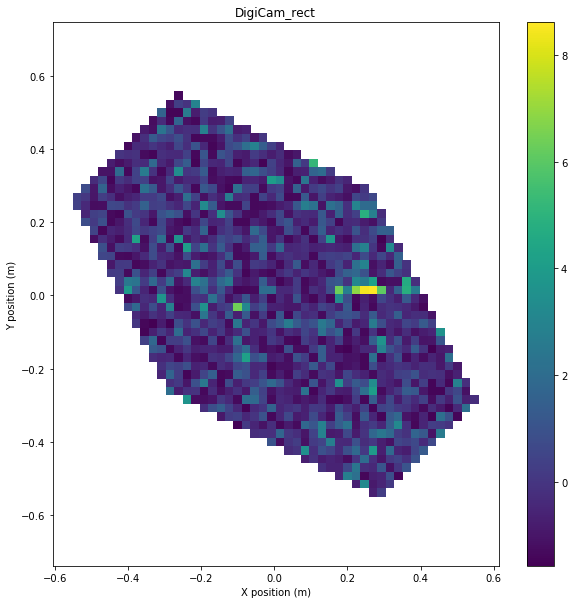

In [19]:
disp = ctapipe.visualization.CameraDisplay(geom2d, image=image2d)
disp.enable_pixel_picker()
disp.add_colorbar()

### Inject noise in blank areas

In [20]:
nan_mask = np.isnan(image2d)

print(np.nanmin(image2d))
print(np.nanmean(image2d))
print(np.nanstd(image2d))

# See https://stackoverflow.com/questions/29365194/replacing-missing-values-with-random-in-a-numpy-array

#image2d[nan_mask] = np.random.poisson(lam=3, size=np.count_nonzero(nan_mask)) - 3.
#image2d[nan_mask] = np.random.normal(0.35, 0.57, size=np.count_nonzero(nan_mask))

dist = EmpiricalDistribution(datapipe.denoising.cdf.DIGICAM_CDF_FILE)
image2d[nan_mask] = dist.rvs(size=np.count_nonzero(nan_mask))

-1.56820494519
0.0496769196968
1.28366676109


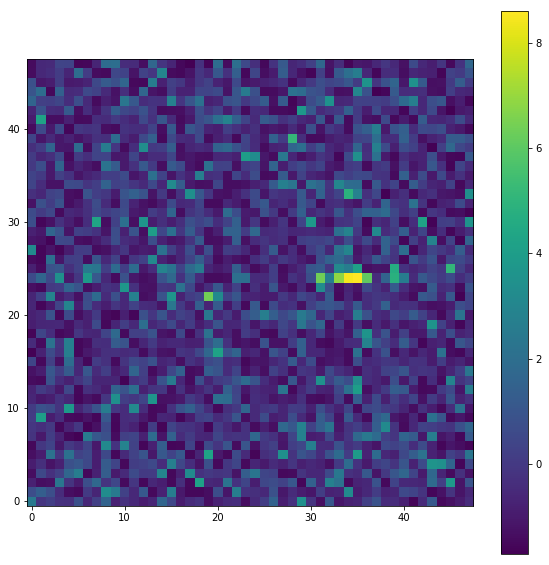

In [21]:
#disp = ctapipe.visualization.CameraDisplay(geom2d, image=image2d)
#disp.enable_pixel_picker()
#disp.add_colorbar()

plt.imshow(image2d, interpolation="nearest", cmap="viridis", origin="lower")
plt.colorbar()

## 2D to 1D

(1296,)


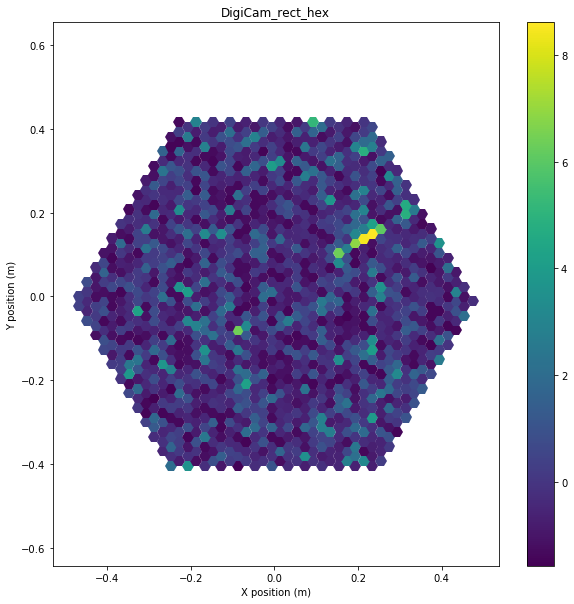

In [22]:
geom1d, image1d = geomconv.convert_geometry_back(geom2d,
                                                 image2d,
                                                 geom.cam_id + str(rot),
                                                 add_rot=rot)

print(image.shape)

disp = ctapipe.visualization.CameraDisplay(geom1d, image=image1d) # Warning: "geom != geom1d" (becauseof the use fo np.histogram to make the conversino) thus use geom1d here, not geom !
disp.enable_pixel_picker()
disp.add_colorbar()